# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

Requires a python capable of supporting these libraries, in my case, I am on a conda environment in 3.7.16:
- numpy>=1.17.2
- tensorflow>=2.0
- tqdm>=4.36.1
- argparse>=1.1
- pandas>=0.25.1
- scikit-learn>=0.21.3
- matplotlib>=3.1.1
- protobuf>=3.20.3

In [20]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [21]:
# Lire le fichier CSV en sautant la première ligne
df = pd.read_csv("data/co2R.csv", skiprows=1)

# Obtenir la valeur maximale
max_value = float(df.max().values)

# Obtenir la valeur minimale
min_value = float(df.min().values)

# Afficher les résultats
print("Valeur maximale :", max_value)
print("Valeur minimale :", min_value)

Valeur maximale : 366.84
Valeur minimale : 313.18


In [22]:
## Data loading
data_name = 'co2R'
seq_len = 365

if data_name in ['stock', 'energy', 'co2', 'co2V', 'co2R']:
  ori_data = real_data_loading(data_name, seq_len)
elif data_name == 'sine':
  # Set number of samples and its dimensions
  no, dim = 130, 1
  ori_data = sine_data_generation(no, seq_len, dim)
    
print(data_name + ' dataset is ready.')
ori_data = np.expand_dims(ori_data,2)
print(ori_data.shape)

co2R dataset is ready.
(103, 365, 1)


## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [23]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 50
parameters['batch_size'] = 64

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [24]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')

Start Embedding Network Training
step: 0/10, e_loss: 0.2362
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10, s_loss: 0.1359
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10, d_loss: 2.5267, g_loss_u: 0.3644, g_loss_s: 0.0832, g_loss_v: 0.2607, e_loss_t0: 0.1895
Finish Joint Training
Finish Synthetic Data Generation


## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [25]:
# metric_iteration = 5

# discriminative_score = list()
# for _ in range(metric_iteration):
#   temp_disc = discriminative_score_metrics(ori_data, generated_data)
#   discriminative_score.append(temp_disc)

# print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [26]:
# predictive_score = list()
# for tt in range(metric_iteration):
#   temp_pred = predictive_score_metrics(ori_data, generated_data)
#   predictive_score.append(temp_pred)   
    
# print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

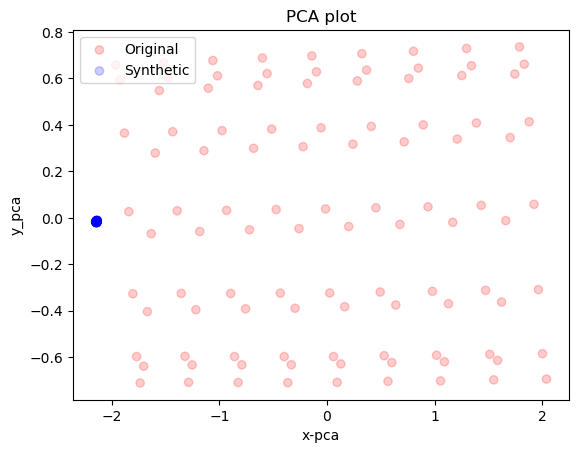

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 206 samples in 0.000s...
[t-SNE] Computed neighbors for 206 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 206 / 206
[t-SNE] Mean sigma: 0.222588
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.625389
[t-SNE] KL divergence after 300 iterations: 0.200287


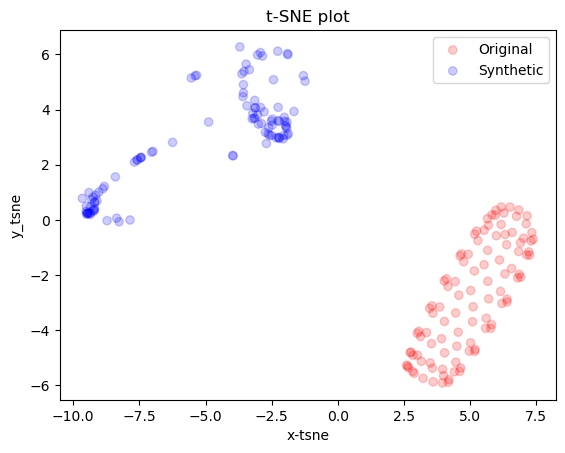

In [27]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')

In [28]:
import matplotlib.pyplot as plt

ori_data_deno = ori_data * (max_value - min_value) + min_value
generated_data_deno = generated_data * (max_value - min_value) + min_value

liste = np.empty((0,), dtype=np.ndarray)

for i in range(generated_data.shape[0]):
    temp = ori_data_deno[i]
    temp = np.squeeze(temp)
    temp2 = generated_data_deno[i]
    temp2 = np.squeeze(temp2)
    res = np.corrcoef(temp, temp2)[0, 1]
    if(res>=0.6):
        print(res)
        # np.concatenate((liste,[temp2]))
        plt.figure()
        plt.plot(ori_data_deno[i], label='Original')
        plt.plot(generated_data_deno[i], label='Generer')
        plt.legend()
plt.show()
print(liste)

[]


In [29]:
import numpy as np

flattened_array1 = ori_data_deno.reshape((-1, ori_data_deno.shape[-1]))
flattened_array2 = generated_data_deno.reshape((-1, generated_data_deno.shape[-1]))

# Spécifier le nom du fichier
f1 = 'output/ori_data.csv'
f2 = 'output/generated_data.csv'

# Utiliser la fonction savetxt pour enregistrer le tableau dans le fichier CSV
np.savetxt(f1, flattened_array1, delimiter=',')
np.savetxt(f2, flattened_array2, delimiter=',')

print("Le tableau a été enregistré dans le fichier CSV avec succès.")

Le tableau a été enregistré dans le fichier CSV avec succès.
